# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#sns.set_theme('whitegrid')

# Define parameters

In [2]:
r_folder = f'models/free-energies'
t_folder = f'targets/free-energies-300K'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std':      f'{r_folder}/ref_dataset_std.pt',
    'r_std_parameters':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data': f'{r_folder}/uncertainty_data.json',
    'model':              f'{r_folder}/model.pt',
    't_dataset':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
# Note that you can as well load a non-standardized dataset and
# then use the cld.standardize_dataset_from_keys function
r_dataset_std = torch.load(files_names['r_dataset_std'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Target dataset

In [5]:
# Load the standardized dataset, with corresponding labels and parameters
# We provide the cld.generate_dataset to generate the dataset
# from an existing database if this does not exist yet
if not os.path.exists(files_names['t_dataset']):
    # Generate data
    cld.generate_dataset(f'{t_folder}/MChX-bandgap',
                         targets=['bandgap'],
                         data_folder=t_folder)
t_dataset = torch.load(files_names['t_dataset'], weights_only=False)

# Include temperature
for graph in t_dataset:
    node_features = torch.tensor([300], dtype=torch.float)
    graph.x = torch.cat((graph.x, node_features.unsqueeze(0).repeat(graph.x.size(0), 1)), dim=1)

# Extract the ground-truths, or input them manually
# This is only requested for testing the performance of the method, not for actual production
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(5, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Plot target predictions

In [9]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, novelties = clm.forward_predictions(r_dataset_std,
                                                                t_dataset_std,
                                                                model, r_std_parameters, r_uncertainty_data)

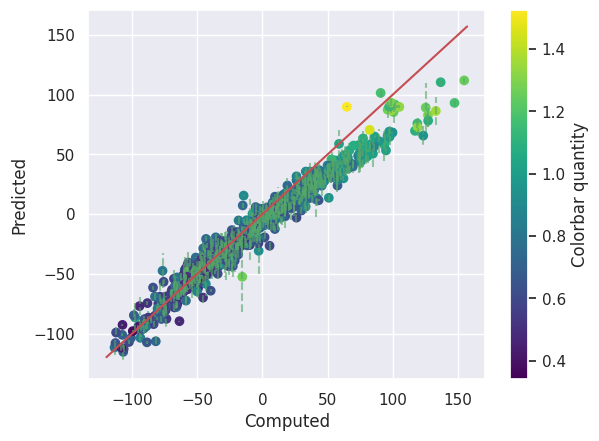

In [16]:
#random_integers = np.random.randint(0, len(ground_truths), size=50)

#ground_truths    = ground_truths[random_integers]
#predictions      = predictions[random_integers]
#uncertainties    = uncertainties[random_integers]
#novelties        = novelties[random_integers]

# Scatter plot with color mapping
sc = plt.scatter(
    ground_truths,
    predictions,
    c=novelties,
    cmap='viridis',
    marker='o'
)

# Error bars
for x, y, err in zip(ground_truths, predictions, uncertainties):
    plt.plot([x, x], [y - err, y + err], 'g--', alpha=0.6)

# Add identity line
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)

cbar = plt.colorbar(sc)
cbar.set_label('Colorbar quantity')

plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.savefig(f'{t_folder}/UQ-target-prediction-comparison.pdf', dpi=30, bbox_inches='tight')
plt.show()

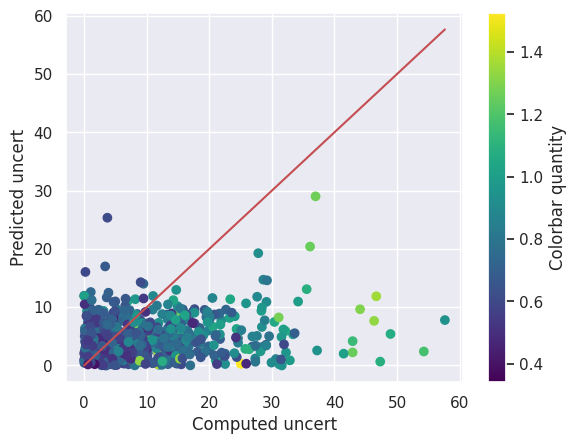

In [17]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

# Scatter plot with color mapping
sc = plt.scatter(
    gt_uncertainties,
    pred_uncertainties,
    c=novelties,
    cmap='viridis',
    marker='o'
)

# Add identity line
_min_, _max_ = cld.get_min_max(
    gt_uncertainties,
    pred_uncertainties
)

cbar = plt.colorbar(sc)
cbar.set_label('Novelty')

plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.savefig(f'{t_folder}/UQ-target-values-comparison.pdf', dpi=30, bbox_inches='tight')
plt.show()

# Plot reference predictions

In [18]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, novelties = clm.forward_predictions(r_dataset_std,
                                                                r_dataset_std,
                                                                model, r_std_parameters, r_uncertainty_data)

In [19]:
ground_truths = np.array([data.y.item() for data in r_dataset_std])
ground_truths = ground_truths * r_std_parameters['target_std'] / r_std_parameters['scale'] + r_std_parameters['target_mean']

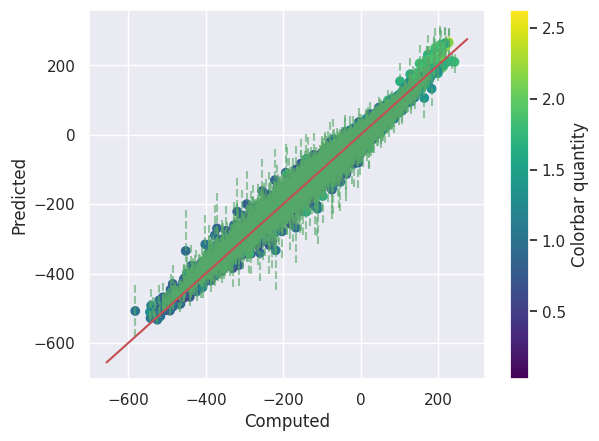

In [20]:
#random_integers = np.random.randint(0, len(ground_truths), size=50)

#ground_truths    = ground_truths[random_integers]
#predictions      = predictions[random_integers]
#uncertainties    = uncertainties[random_integers]
#novelties        = novelties[random_integers]

# Scatter plot with color mapping
sc = plt.scatter(
    ground_truths,
    predictions,
    c=novelties,
    cmap='viridis',
    marker='o'
)

# Error bars
for x, y, err in zip(ground_truths, predictions, uncertainties):
    plt.plot([x, x], [y - err, y + err], 'g--', alpha=0.6)

# Add identity line
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)

cbar = plt.colorbar(sc)
cbar.set_label('Colorbar quantity')

plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.savefig(f'{t_folder}/UQ-target-prediction-comparison.pdf', dpi=30, bbox_inches='tight')
plt.show()

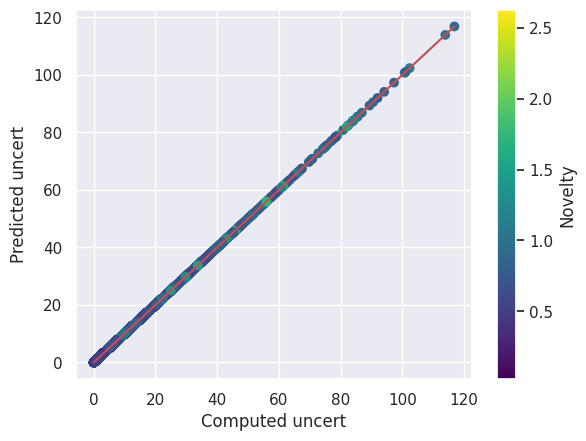

In [22]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

# Scatter plot with color mapping
sc = plt.scatter(
    gt_uncertainties,
    pred_uncertainties,
    c=novelties,
    cmap='viridis',
    marker='o'
)

# Add identity line
_min_, _max_ = cld.get_min_max(
    gt_uncertainties,
    pred_uncertainties
)

cbar = plt.colorbar(sc)
cbar.set_label('Novelty')

plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.savefig(f'{t_folder}/UQ-target-values-comparison.pdf', dpi=30, bbox_inches='tight')
plt.show()